# Mann-Whitney U Test to detect Deviations in Pollutant Levels

Visualize and compare current year pollutant levels with past years using AQICN data. Select city, pollutant, time-frame, and number of past years to display. A plot will be generated for quick inspection. A box plot and results of a Mann-Whitney U test are also returned.  

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import mannwhitneyu

def load_data(filepath, chunk=None):
    df = pd.read_csv(filepath, skipinitialspace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.sort_values(by='date').reset_index(drop=True)
    
    if chunk in ['week', 'month']:
        df = df.set_index('date')
        if chunk == 'week':
            df = df.resample('W').mean()
        elif chunk == 'month':
            df = df.resample('M').mean()
        df = df.reset_index()
    
    return df

# Fix for matplotlib version compatibility: use 'labels' instead of 'tick_labels'
def analyze_and_plot_period_with_boxplot(
    df,
    pollutant,
    start_str,
    end_str,
    target_year=2025,
    years_back=None
):
    df = df.copy()
    df['month_day'] = df['date'].dt.strftime('%m-%d')
    df['year'] = df['date'].dt.year

    # Filter to the selected MM-DD date range
    in_range = df[(df['month_day'] >= start_str) & (df['month_day'] <= end_str)]

    # Apply years_back filter if specified
    if years_back is not None:
        valid_years = list(range(target_year - years_back, target_year))
        in_range = in_range[in_range['year'].isin(valid_years + [target_year])]

    # Normalize all dates to a fixed year for plotting
    in_range['plot_date'] = in_range['date'].apply(lambda d: d.replace(year=2000))

    # Separate data
    group_target = in_range[in_range['year'] == target_year][pollutant].dropna()
    group_past = in_range[in_range['year'] < target_year][pollutant].dropna()

    # Mann-Whitney U Test
    stat, p_val = mannwhitneyu(group_target, group_past, alternative='two-sided')

    # Line plot
    plt.figure(figsize=(10, 6))
    years = sorted(in_range['year'].unique())

    for yr in years:
        year_data = in_range[in_range['year'] == yr]
        color = 'dimgray' if yr == target_year else 'lightgray'
        plt.plot(year_data['plot_date'], year_data[pollutant], color=color, linewidth=2 if yr == target_year else 1)
        if not year_data.empty:
            last_date = year_data['plot_date'].max()
            last_value = year_data[year_data['plot_date'] == last_date][pollutant].values[0]
            plt.text(last_date, last_value, str(yr), fontsize=8,
                     color=color, ha='left', va='center')

    title_years = f"Last {years_back} Years" if years_back else "All Years"
    plt.title(f"{pollutant.upper()} Levels from {start_str} to {end_str} ({target_year} vs {title_years})")
    plt.xlabel("Day of Year")
    plt.ylabel(f"{pollutant.upper()} Concentration")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.tight_layout()
    plt.show()

    # Boxplot (use 'labels' for compatibility)
    plt.figure(figsize=(8, 5))
    plt.boxplot([group_past, group_target], tick_labels=[f'Past Years', f'{target_year}'])
    plt.title(f'{pollutant.upper()} Levels: {start_str} to {end_str} ({target_year} vs Past)')
    plt.ylabel(f'{pollutant.upper()} Concentration')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    result_table = pd.DataFrame({
        "Metric": [
            "U Statistic",
            "P-Value",
            "Sample Size (Target)",
            "Sample Size (Past)",
            "Median (Target)",
            "Median (Past)"
        ],
        "Value": [
            round(stat, 2),
            round(p_val, 4),
            len(group_target),
            len(group_past),
            round(group_target.median(), 2),
            round(group_past.median(), 2)
        ]
    })

    return result_table

## Plots and Statistical Result

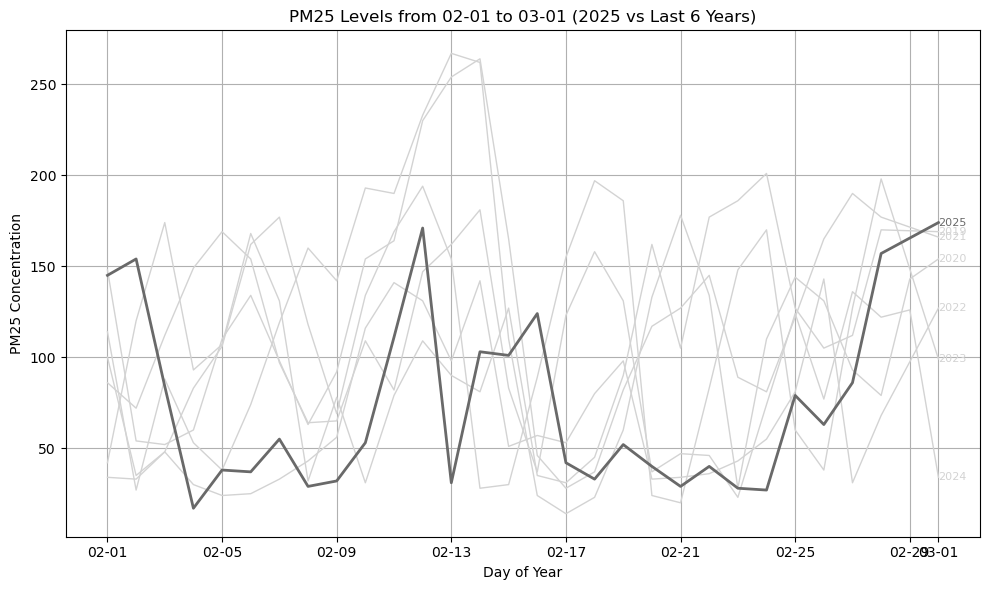

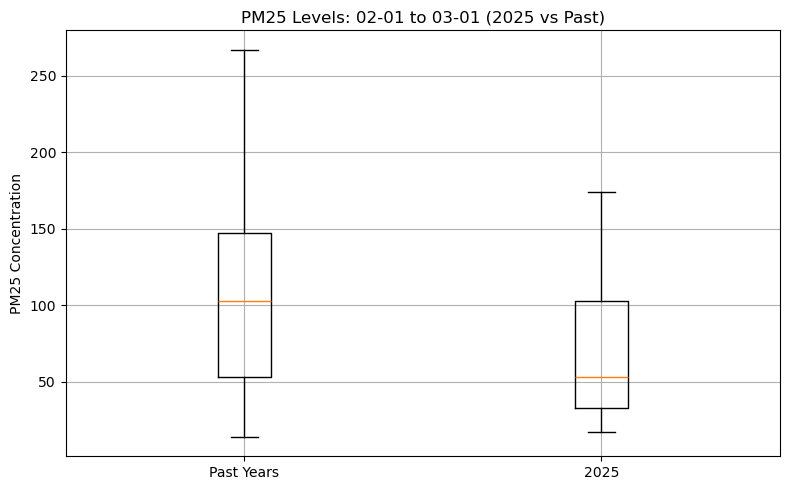

                 Metric      Value
0           U Statistic  1747.0000
1               P-Value     0.0066
2  Sample Size (Target)    29.0000
3    Sample Size (Past)   176.0000
4       Median (Target)    53.0000
5         Median (Past)   102.5000


In [17]:
# Example usage
city = load_data("aqicn_data/beijing.csv")

result = analyze_and_plot_period_with_boxplot(
    df=city,
    pollutant='pm25',
    start_str='02-01',
    end_str='03-01',
    target_year=2025,
    years_back=6
)

print(result)